# Performing Cuts on Jets Using Masks

In [1]:
import awkward as ak
import numpy as np
import coffea
import uproot
import hist
import vector
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from dask.distributed import Client
import matplotlib.pyplot as plt
from distributed.diagnostics.plugin import UploadDirectory
from collections import defaultdict
import correctionlib
from coffea.analysis_tools import PackedSelection

In [2]:
my_file = 'root://xcache//store/mc/RunIISummer20UL16NanoAODAPVv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to75_106X_mcRun2_asymptotic_preVFP_v11-v1/120000/0AC69980-C070-954D-A349-3F134CC8E5B8.root'
#my_file = 'root://xcache//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to75_20UL17JMENano_106X_mc2017_realistic_v9-v1/60000/044B12F6-C47A-A143-9A1D-6FC0A863E6AB.root'
#my_file = 'root://xcache//store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to75_20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/2550000/00C4553F-498A-6C43-8144-3CE0FE0CEC15.root'
my_events = NanoEventsFactory.from_root(my_file, schemaclass=NanoAODSchema).events()

### Array Masks

Now that we have a better understanding of how to interpret the content of our files, we can start performing cuts on our events to filter our uninteresting points. As before, we will focus on the `GenJet` and `Jet` TBranches of our files, and for each display the total number of events and jets they contain:

In [3]:
gen_jets = my_events.GenJet
reco_jets = my_events.Jet

for i, j in zip(gen_jets[:4], reco_jets[:4]):
    print(f"Number of gen_jets = {len(i)} --------> {i}")
    print(f"Number of reco_jets = {len(j)} --------> {j}\n")
    
print(f"Number of events in gen_jets, no mask --------> {ak.num(gen_jets, axis=0)}\nNumber of events in reco_jets, no mask --------> {ak.num(reco_jets, axis=0)}")
print(f"Number of jets in gen_jets, no mask --------> {ak.sum(ak.num(gen_jets, axis=1))}\nNumber of jets in reco_jets, no mask --------> {ak.sum(ak.num(reco_jets,axis=1))}")
print(f"Ratio of number of gen_jets to reco_jets, no mask --------> {ak.sum(ak.num(gen_jets, axis=1)) / ak.sum(ak.num(reco_jets,axis=1))}\n")

Number of gen_jets = 2 --------> [{eta: 2.12, mass: 3.82, phi: -2.26, ... partonFlavour: -1, hadronFlavour: 0}]
Number of reco_jets = 1 --------> [Jet]

Number of gen_jets = 5 --------> [{eta: -2.65, mass: 5.93, phi: 2.71, ... partonFlavour: 2, hadronFlavour: 0}]
Number of reco_jets = 5 --------> [Jet, Jet, Jet, Jet, Jet]

Number of gen_jets = 4 --------> [{eta: -1.44, mass: 8.07, phi: 0.343, ... partonFlavour: 21, hadronFlavour: 0}]
Number of reco_jets = 7 --------> [Jet, Jet, Jet, Jet, Jet, Jet, Jet]

Number of gen_jets = 2 --------> [{eta: 1.29, mass: 5.98, phi: -1.78, ... partonFlavour: 21, hadronFlavour: 0}]
Number of reco_jets = 16 --------> [Jet, Jet, Jet, Jet, Jet, Jet, Jet, Jet, Jet, Jet, Jet, Jet, Jet, Jet, Jet, Jet]

Number of events in gen_jets, no mask --------> 1382600
Number of events in reco_jets, no mask --------> 1382600
Number of jets in gen_jets, no mask --------> 6844111
Number of jets in reco_jets, no mask --------> 13357921
Ratio of number of gen_jets to reco_jet

This is our raw data corrensponding to no cuts being made. We have the same number of events for `gen_jets` and `reco_jets`, but there are more recontructed jets than MC jets. Next comes our first mask, which we will use to filter out all the events for which the separation of between the `gen_jets` and `reco_jets` vertices is greater than $0.2$ in the z-direction, but keep them otherwise. Events that have this mask active will have a `_vtx` suffix:

In [4]:
gen_vtx = my_events.GenVtx.z
reco_vtx = my_events.PV.z
vtx_mask = np.abs(gen_vtx - reco_vtx) < 0.2

my_events_vtx = my_events[vtx_mask]
gen_jets_vtx = my_events_vtx.GenJet
reco_jets_vtx = my_events_vtx.Jet

print(f"Number of events in gen_jets, vtx_mask --------> {ak.num(gen_jets_vtx, axis=0)}\nNumber of events in reco_jets, vtx_mask --------> {ak.num(reco_jets_vtx, axis=0)}")
print(f"Number of jets in gen_jets, vtx_mask --------> {ak.sum(ak.num(gen_jets_vtx, axis=1))}\nNumber of jets in reco_jets, vtx_mask --------> {ak.sum(ak.num(reco_jets_vtx, axis=1))}")
print(f"Ratio of number of gen_jets to reco_jets, vtx_mask --------> {ak.sum(ak.num(gen_jets_vtx, axis=1)) / ak.sum(ak.num(reco_jets_vtx, axis=1))}\n")

Number of events in gen_jets, vtx_mask --------> 1216480
Number of events in reco_jets, vtx_mask --------> 1216480
Number of jets in gen_jets, vtx_mask --------> 6319642
Number of jets in reco_jets, vtx_mask --------> 11291200
Ratio of number of gen_jets to reco_jets, vtx_mask --------> 0.5596962236077654



As we can see, the number of events for `gen_jets` and `reco_jets` are still equal, but have been reduced by $166,120$ while the total number of each jet has been reduced by $524,469$ and $2,066,721$ respectively. We now apply our next mask, which will filter out all reconstructed jets with jetId = $0$, and then only keep the events than have one or more such jets. Events with the vertex and ID masks will have a `_vtx_id` suffix:

In [5]:
id_mask = reco_jets_vtx.jetId > 0
reco_jets_vtx_id = reco_jets_vtx[id_mask]
my_events_vtx_id = my_events_vtx[ak.num(reco_jets_vtx_id, axis=1) > 0]

gen_jets_vtx_id = my_events_vtx_id.GenJet
reco_jets_vtx_id = my_events_vtx_id.Jet

print(f"Number of events in gen_jets, vtx and ID masks --------> {ak.num(gen_jets_vtx_id, axis=0)}\nNumber of events in reco_jets, vtx_mask --------> {ak.num(reco_jets_vtx_id, axis=0)}")
print(f"Number of jets in gen_jets, vtx and ID masks --------> {ak.sum(ak.num(gen_jets_vtx_id, axis=1))}\nNumber of jets in reco_jets, vtx_mask --------> {ak.sum(ak.num(reco_jets_vtx_id, axis=1))}")
print(f"Ratio of number of gen_jets to reco_jets, vtx and ID masks --------> {ak.sum(ak.num(gen_jets_vtx_id, axis=1)) / ak.sum(ak.num(reco_jets_vtx_id, axis=1))}\n")

Number of events in gen_jets, vtx and ID masks --------> 1211269
Number of events in reco_jets, vtx_mask --------> 1211269
Number of jets in gen_jets, vtx and ID masks --------> 6309688
Number of jets in reco_jets, vtx_mask --------> 11290021
Ratio of number of gen_jets to reco_jets, vtx and ID masks --------> 0.5588730082964416



The number of events for `gen_jets` and `reco_jets` have now been reduced by a further $5,211$, while the jets in `gen_jets` and `reco_jets` are reduced by $9,954$ and $1,179$ respectively. One final trimming of our jets is perfomed by keeping the first three leading jets of our masked `gen_jets`, and then only keeping the jets in `reco_jet` that are within a set threshold distance of the jets in `gen_jets`:

In [6]:
gen_jets_final = gen_jets_vtx_id[:, :3]
reco_jets_final = gen_jets_final.nearest(reco_jets_vtx_id, threshold=0.2)

print(f"Number of events in gen_jets, vtx_mask --------> {ak.num(gen_jets_final, axis=0)}\nNumber of events in reco_jets, vtx_mask --------> {ak.num(reco_jets_final, axis=0)}")
print(f"Number of jets in gen_jets, vtx_mask --------> {ak.sum(ak.num(gen_jets_final, axis=1))}\nNumber of jets in reco_jets, vtx_mask --------> {ak.sum(ak.num(reco_jets_final, axis=1))}")
print(f"Ratio of number of gen_jets to reco_jets, vtx_mask --------> {ak.sum(ak.num(gen_jets_final, axis=1)) / ak.sum(ak.num(reco_jets_final, axis=1))}\n")

Number of events in gen_jets, vtx_mask --------> 1211269
Number of events in reco_jets, vtx_mask --------> 1211269
Number of jets in gen_jets, vtx_mask --------> 3504811
Number of jets in reco_jets, vtx_mask --------> 3504811
Ratio of number of gen_jets to reco_jets, vtx_mask --------> 1.0



This time the number of events remain the same, but `gen_jets` and `reco_jets` have been reduced by $2,804,877$ and $7,785,210$ jets respectively. Importantly, the number or reconstructed jets equals the number of MC jets, so we can take their ratios to calculate a
jet response.

### Plotting Masked Kinematics

Lets plot the jet $p_T$ distributions for different masks to show their effect:

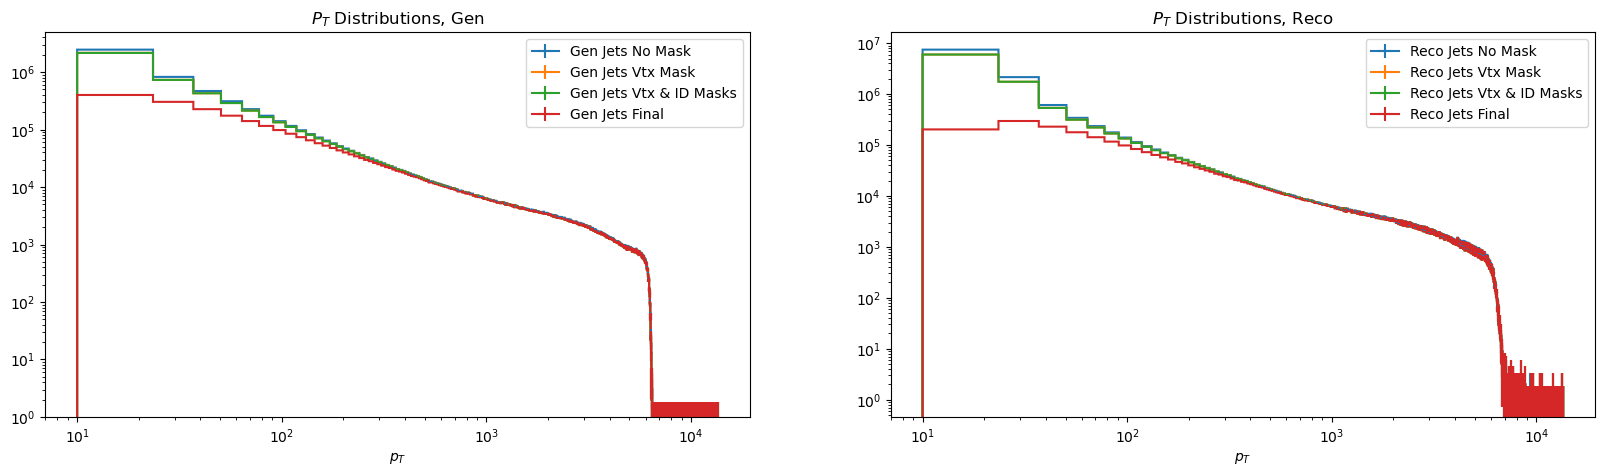

In [7]:
pt_axis = hist.axis.Regular(1000, 10, 13500, name="pt", label="$p_T$")

gen_jets_hist, reco_jets_hist = hist.Hist(pt_axis), hist.Hist(pt_axis)
gen_jets_hist_vtx, reco_jets_hist_vtx = hist.Hist(pt_axis), hist.Hist(pt_axis)
gen_jets_hist_vtx_id, reco_jets_hist_vtx_id = hist.Hist(pt_axis), hist.Hist(pt_axis)
gen_jets_hist_final, reco_jets_hist_final = hist.Hist(pt_axis), hist.Hist(pt_axis)

gen_jets_hist.fill(pt=ak.ravel(gen_jets.pt))
reco_jets_hist.fill(pt=ak.ravel(reco_jets.pt))
gen_jets_hist_vtx.fill(pt=ak.ravel(gen_jets_vtx.pt))
reco_jets_hist_vtx.fill(pt=ak.ravel(reco_jets_vtx.pt))
gen_jets_hist_vtx_id.fill(pt=ak.ravel(gen_jets_vtx_id.pt))
reco_jets_hist_vtx_id.fill(pt=ak.ravel(reco_jets_vtx_id.pt))
gen_jets_hist_final.fill(pt=ak.ravel(gen_jets_final.pt))
reco_jets_hist_final.fill(pt=ak.ravel(reco_jets_final.pt))

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

gen_jets_hist.project('pt').plot(ax=axs[0], label="Gen Jets No Mask")
gen_jets_hist_vtx.project('pt').plot(ax=axs[0], label="Gen Jets Vtx Mask")
gen_jets_hist_vtx_id.project('pt').plot(ax=axs[0], label="Gen Jets Vtx & ID Masks")
gen_jets_hist_final.project('pt').plot(ax=axs[0], label="Gen Jets Final")

reco_jets_hist.project('pt').plot(ax=axs[1], label="Reco Jets No Mask")
reco_jets_hist_vtx.project('pt').plot(ax=axs[1], label="Reco Jets Vtx Mask")
reco_jets_hist_vtx_id.project('pt').plot(ax=axs[1], label="Reco Jets Vtx & ID Masks")
reco_jets_hist_final.project('pt').plot(ax=axs[1], label="Reco Jets Final")

axs[0].set_title("$P_T$ Distributions, Gen")
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend()

axs[1].set_title("$P_T$ Distributions, Reco")
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].legend()
plt.show()

The reduction in events as the masks are applied is evident, and so we now focus on the final $p_T$ distributions:

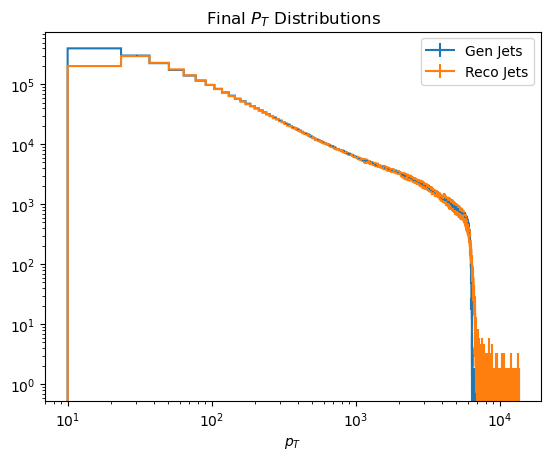

In [8]:
gen_jets_histogram, reco_jets_histogram = hist.Hist(pt_axis), hist.Hist(pt_axis)

gen_jets_histogram.fill(pt=ak.ravel(gen_jets_final.pt))
reco_jets_histogram.fill(pt=ak.ravel(reco_jets_final.pt))

gen_jets_histogram.project("pt").plot(label="Gen Jets")
reco_jets_histogram.project("pt").plot(label="Reco Jets")

plt.title("Final $P_T$ Distributions")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In a perfect situation the $p_T$ distribution of `gen_jets_final` would match that of `reco_jets_final`, however this is clearly not the case as seen in the plots above. To quantify how much they differ by, we introduce the jet $p_T$ response defined as the ratio $p_{T}^{RESP} = p_{T}^{RECO} \hspace{1mm} / \hspace{1mm} p_{T}^{GEN}$ of our jets. We plot this quantity in the cell below, but before doing so we will apply two further masks: `sel_1` filters out the few elements in our collections that are `NoneType`, and then `sel_2` only keeps the events that have three jets, which is a relatively small amount of jets. A final cut is applied to discard events with high $p_T$ responses, but this is also a relatively small cut.

Events with less than 3 Jets = 26



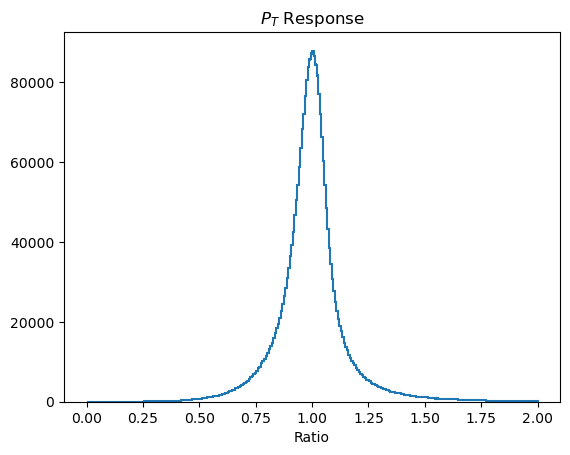

In [9]:
pt_response = reco_jets_final.pt /gen_jets_final.pt
frac_axis = hist.axis.Regular(300, 0, 2, name="frac", label="Ratio")

sel_1 = ~ak.is_none(reco_jets_final, axis = 1)

reco_jets = reco_jets_final[sel_1]
gen_jets = gen_jets_final[sel_1]
pt_response = pt_response[sel_1]

sel_2 = ak.num(pt_response) > 2

reco_jets = reco_jets[sel_2]
gen_jets = gen_jets[sel_2]
pt_response = pt_response[sel_2]
pt_response = pt_response[pt_response <= 2]

counter = 0
for i, item in enumerate(ak.num(pt_response), start=1):  
    if item < 2:
        counter += 1
        #print(i, item)
    else:
        continue
        
print(f"Events with less than 3 Jets = {counter}\n")

response_histogram = hist.Hist(frac_axis)

response_histogram.fill(frac=ak.ravel(pt_response))

response_histogram.project("frac").plot()

plt.title("$P_T$ Response")
plt.show()

The repsonse distribution has the shape of a gaussian centered at $1$ as we expect. The main goal of our analysis is to eventually fit this response to a gaussian function, and extract the width of the fit. We will then repeat this for our entire dataset, and then plot the widths of these gaussian fits as functions of the transverse momentum to obtain Jet Energy Resolution (JER) curves.

### Plotting Masked Pileup Observables

For completeness, lets apply our masking procedure to the pileup observables as well:

In [10]:
n_reco_vtx = my_events_vtx_id.PV.npvs
n_pileup = my_events_vtx_id.Pileup.nPU
reco_rho = my_events.fixedGridRhoFastjetAll
pu_nTrueInt = my_events.Pileup.nTrueInt

print(f"Max rho value: {np.max(reco_rho)}")
print(f"Max number of reconstructed PV: {np.max(n_reco_vtx)}")
print(f"Max number of PU interactions added: {np.max(n_pileup)}")
print(f"Max nTrueInt value: {np.max(reco_rho)}\n")

Max rho value: 94.52728271484375
Max number of reconstructed PV: 173
Max number of PU interactions added: 110
Max nTrueInt value: 94.52728271484375



To these arrays, we apply our `sel_2` mask in order to make them the same size as the `reco_jets` collection, and then we define new corresponding arrays by broadcasting the pileup obervables with `reco_jets`. Lastly, we plot the histograms of all distributions, and notice there is no difference between the broadcasted and regular observables.

In [11]:
n_reco_vtx = n_reco_vtx[sel_2]
n_pileup = n_pileup[sel_2]
reco_rho = reco_rho[sel_2]
pu_nTrueInt = pu_nTrueInt[sel_2]

broad_n_reco_vtx = ak.broadcast_arrays(n_reco_vtx, reco_jets.pt)[0]
broad_n_pileup = ak.broadcast_arrays(n_pileup, reco_jets.pt)[0]
broad_reco_rho = ak.broadcast_arrays(reco_rho, reco_jets.pt)[0]
broad_pu_nTrueInt = ak.broadcast_arrays(pu_nTrueInt, reco_jets.pt)[0]   
        
print(f"Max rho value: {np.max(reco_rho)}")
print(f"Max number of reconstructed PV: {np.max(n_reco_vtx)}")
print(f"Max number of PU interactions added: {np.max(n_pileup)}")
print(f"Max nTrueInt value: {np.max(reco_rho)}\n")

Max rho value: 86.67204284667969
Max number of reconstructed PV: 173
Max number of PU interactions added: 110
Max nTrueInt value: 86.67204284667969



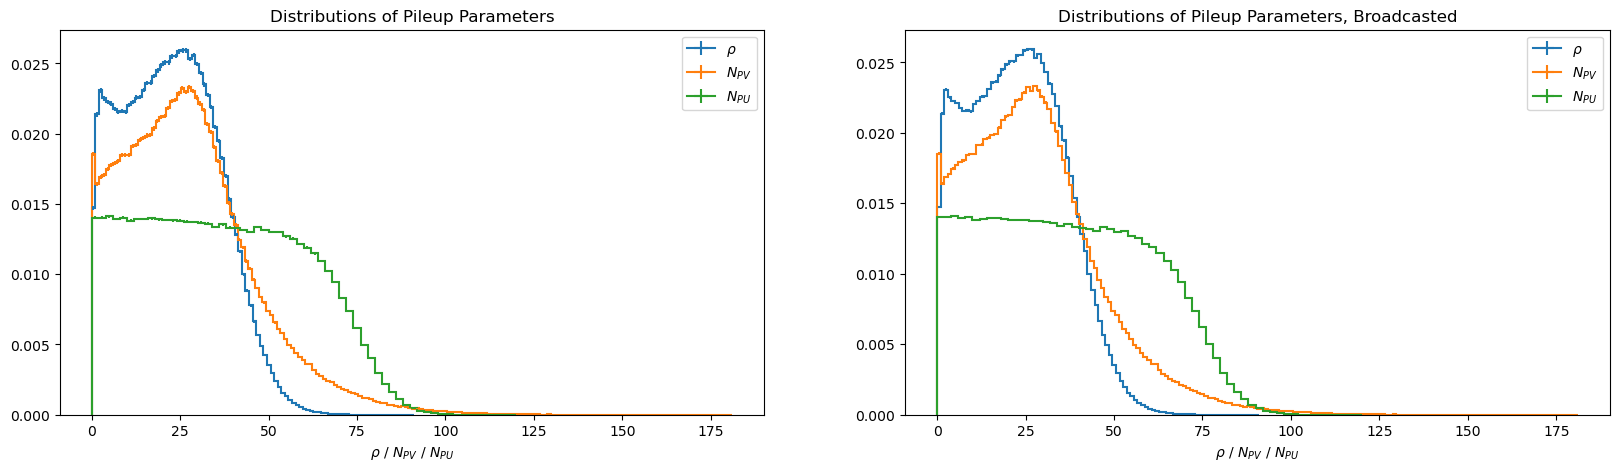

In [12]:
rho_axis = hist.axis.Regular(90, 0, 91, name="rho")
npvs_axis = hist.axis.Regular(180, 0, 181, name="npvs")
npu_axis = hist.axis.Regular(60, 0, 120, name="npu")

corrections_histogram = hist.Hist(rho_axis, npvs_axis, npu_axis)
broad_corrections_histogram = hist.Hist(rho_axis, npvs_axis, npu_axis)

corrections_histogram.fill(rho=ak.ravel(reco_rho), npvs=ak.ravel(n_reco_vtx), npu=ak.ravel(n_pileup))
broad_corrections_histogram.fill(rho=ak.ravel(broad_reco_rho), npvs=ak.ravel(broad_n_reco_vtx), npu=ak.ravel(broad_n_pileup))

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

corrections_histogram.project('rho').plot(ax=axs[0], density=True, label=r"$\rho$")
corrections_histogram.project('npvs').plot(ax=axs[0], density=True, label="$N_{PV}$")
corrections_histogram.project('npu').plot(ax=axs[0], density=True, label="$N_{PU}$")
broad_corrections_histogram.project('rho').plot(ax=axs[1], density=True, label=r"$\rho$")
broad_corrections_histogram.project('npvs').plot(ax=axs[1], density=True, label="$N_{PV}$")
broad_corrections_histogram.project('npu').plot(ax=axs[1], density=True, label="$N_{PU}$")

axs[0].set_title("Distributions of Pileup Parameters")
axs[0].set_xlabel(r"$\rho$ / $N_{PV}$ / $N_{PU}$")
axs[0].legend()

axs[1].set_title("Distributions of Pileup Parameters, Broadcasted")
axs[1].set_xlabel(r"$\rho$ / $N_{PV}$ / $N_{PU}$")
axs[1].legend()
plt.show()